<h4> <font color=darkolivegreen>Necessary Functions</font> </h4>

In [1]:
#AHG exp function
def regress(data, yvar, xvars):
    Y = np.log(data[yvar])
    X = np.log(data[xvars])
    X['intercept'] = 1.
    result = sm.OLS(Y, X).fit()
    return result.params[0] #only get exp

#AHG int function
def regress2(data, yvar, xvars):
    Y = np.log(data[yvar])
    X = np.log(data[xvars])
    X['intercept'] = 1.
    result = sm.OLS(Y, X).fit()
    return result.params[1] #only get int

#bankfull hydraulics function
def calculate_bankful(df, colname, retPeriod):
    # sort data smallest to largest
    sorted_data = df.sort_values(by=colname, ascending = False)
    # count total obervations
    n = sorted_data.shape[0]
    # add a numbered column 1 -> n to use in return calculation for rank
    sorted_data.insert(0, 'rank', range(1, 1 + n))
    #find desired rank
    desiredRank = (n+1)/retPeriod
    desiredRank = round(desiredRank)
    #get variable with desired rank
    output = sorted_data.loc[sorted_data['rank'] == desiredRank, colname]
    return(output)

#AHG r2 function
def regress3(data, yvar, xvars):
    Y = np.log(data[yvar])
    X = np.log(data[xvars])
    X['intercept'] = 1.
    result = sm.OLS(Y, X).fit()
    return result.rsquared #only get r2

In [2]:
import pandas as pd
import os
import numpy as np
import scipy.stats.mstats as sp
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import math
from IPython.display import display, HTML
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn import linear_model
from pandas.plotting import scatter_matrix
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from math import sqrt
from ast import literal_eval

#Flag to remove 'not-independnt' river measurements for SWOT tests (set to 1). Not actually implemented in geoBAM
SWOTflag = 1

#set working directory
os.chdir("C:\\Users\\craig\\Box Sync\\Ongoing Projects\\geomorph_class\\")

#load in necessary datasets
Hydroshortened = pd.read_csv('classification_data\\Hydraulics_data.csv', low_memory=False, encoding='latin-1') #hydraulic data (Brinkerhoff etal 2019)
med_NHD_lakes = pd.read_csv('classification_data\\med_NHD_lakes.csv', low_memory=False, encoding='latin-1') #NHD lakes
med_NHD = pd.read_csv('classification_data\\NHD_med_res.csv', low_memory=False, encoding='latin-1') #NHD flowlines (with USGS gauges snapped to them)



#For SWOT tests, we need to remove all measurements from SWOT rivers in the US (to be completely indpendent).
    #We manually identified usgs gauges on these SWOT-simulated rivers and manually remove them here.
    #no gauges along Mississippi downstream
    #NOTE: the location of these hydraulic models is often coarsely defined by the papers associated with them (availble
    #via Durand et al. 2016). We did our best to manually identify all USGS gauges along these sections of river, but might
    #have missed a gauge or two in some rivers whose sptial location were poorly defined (i.e Sacramento, CT)
ctIDs = [1172000, 1172003, 1184000, 1183998, 1190070, 1193000, 1193050, 1172010]
platteIDs = [6768000, 6768035, 6768025, 6770200, 6770500]
ohioIDs = [3293548, 3293600, 3293550, 3293551, 3294500, 3294600, 327720, 3255000, 3384500, 3399800, 3322420, 
          3322000, 3322190, 3304300, 3303280, 3303500, 3611500, 3612500, 3612600, 3381700]
cumberlandIDs = [34315005, 3438500, 3438475, 3438220, 3437000, 3436500, 3435000, 3434900, 3431500, 3426500,
                3426310, 3425400, 3425000, 3418420, 3417500, 3414110]
kanawhaIDs = [3198000, 3201301]
wabashIDs = [3378500, 3377500]
MIupIDs = [7020500]
sacIDs = [11389470, 11389350, 11389390, 11391000, 11391002, 11391021, 11391020, 11390500, 11390480, 11389500, 11425500, 11447500, 11447650]
if SWOTflag == 1:
    med_NHD = med_NHD[med_NHD['SOURCE_FEA'].isin(ctIDs).astype(int) == False]
    med_NHD = med_NHD[med_NHD['SOURCE_FEA'].isin(platteIDs).astype(int) == False]
    med_NHD = med_NHD[med_NHD['SOURCE_FEA'].isin(ohioIDs).astype(int) == False]
    med_NHD = med_NHD[med_NHD['SOURCE_FEA'].isin(cumberlandIDs).astype(int) == False]
    med_NHD = med_NHD[med_NHD['SOURCE_FEA'].isin(kanawhaIDs).astype(int) == False]
    med_NHD = med_NHD[med_NHD['SOURCE_FEA'].isin(wabashIDs).astype(int) == False]
    med_NHD = med_NHD[med_NHD['SOURCE_FEA'].isin(MIupIDs).astype(int) == False]
    med_NHD = med_NHD[med_NHD['SOURCE_FEA'].isin(sacIDs).astype(int) == False]

#NHD sinuosity from  Wieczorek, M.E., Jackson, S.E., and Schwarz, G.E., 2018, Select Attributes for NHDPlus Version 2.1 Reach Catchments and Modified Network Routed Upstream Watersheds for the Conterminous United States: U.S. Geological Survey data release, https://doi.org/10.5066/F7765D7V. 
sinuosityCONUS = pd.read_csv('classification_data\\Sinuousity_CONUS.txt', delimiter=',')
statsgoCONUS = pd.read_csv('classification_data\\STATSGO_CONUS.txt', delimiter=',')

Hydroshortened = pd.merge(Hydroshortened, med_NHD[['SOURCE_FEA', 'COMID', 'SLOPE', 'StreamOrde', 'ArbolateSu', 'Measure', 'LENGTHKM', 'LatSite', 'LonSite', 'FTYPE', 'FCODE', 'DASqKm', 'Tidal', 'WBAREACOMI', 'TOTMA']],left_on='site_no', right_on='SOURCE_FEA')
Hydroshortened = pd.merge(Hydroshortened, sinuosityCONUS, left_on='COMID', right_on='COMID')
Hydroshortened = pd.merge(Hydroshortened, statsgoCONUS, left_on='COMID', right_on='COMID')

In [3]:
#get depth
Hydroshortened['chan_depth'] = Hydroshortened['chan_area']/Hydroshortened['chan_width']

#cleaning NA values and hydraulics below 0 and minimum 20 measurements
Hydroshortened = Hydroshortened[Hydroshortened['chan_width'] > 0]
Hydroshortened = Hydroshortened[Hydroshortened['chan_depth'] > 0]
Hydroshortened = Hydroshortened[Hydroshortened['chan_discharge'] > 0]
Hydroshortened = Hydroshortened[Hydroshortened['measured_rating_diff'] != 'Poor']
Hydroshortened = Hydroshortened[Hydroshortened['measured_rating_diff'] != 'POOR']

Hydroshortened = Hydroshortened[Hydroshortened['chan_width'].notnull()]
Hydroshortened = Hydroshortened[Hydroshortened['chan_depth'].notnull()]
Hydroshortened = Hydroshortened[Hydroshortened['chan_discharge'].notnull()]
Hydroshortened = Hydroshortened[Hydroshortened['chan_width'].notna()]
Hydroshortened = Hydroshortened[Hydroshortened['chan_depth'].notna()]
Hydroshortened = Hydroshortened[Hydroshortened['chan_discharge'].notna()]

#convert needed units to metric
Hydroshortened['chan_width'] = Hydroshortened['chan_width']*0.305
Hydroshortened['chan_depth'] = Hydroshortened['chan_depth']*0.305
Hydroshortened['chan_velocity'] = Hydroshortened['chan_velocity']*0.305
Hydroshortened['chan_discharge'] = Hydroshortened['chan_discharge']*0.028

Hydroshortened['n'] = ((Hydroshortened['chan_depth'])**(2/3)*Hydroshortened['SLOPE']**(1/2))/Hydroshortened['chan_velocity']
Hydroshortened['shearStress'] = 9.81*Hydroshortened['chan_depth']*Hydroshortened['SLOPE']
Hydroshortened['Fb'] = Hydroshortened['chan_velocity']/((Hydroshortened['chan_depth']*9.81)**(1/2))
Hydroshortened['minEntrain'] = 11*Hydroshortened['chan_depth']*Hydroshortened['SLOPE']

#A0- median not minimum
Hydroshortened = Hydroshortened.join(Hydroshortened.groupby('site_no')['chan_area'].agg(['median']), on='site_no')
Hydroshortened = Hydroshortened.rename(columns={"median": "A0"})

#AHG parameters
b_temp = Hydroshortened.groupby('site_no').apply(regress, 'chan_width', ['chan_discharge']).to_frame()
a_temp = Hydroshortened.groupby('site_no').apply(regress2, 'chan_width', ['chan_discharge']).to_frame()
f_temp = Hydroshortened.groupby('site_no').apply(regress, 'chan_depth', ['chan_discharge']).to_frame()
c_temp = Hydroshortened.groupby('site_no').apply(regress2, 'chan_depth', ['chan_discharge']).to_frame()
m_temp = Hydroshortened.groupby('site_no').apply(regress, 'chan_velocity', ['chan_discharge']).to_frame()
k_temp = Hydroshortened.groupby('site_no').apply(regress2, 'chan_velocity', ['chan_discharge']).to_frame()

b_temp = b_temp.rename(columns={0:'b'})
Hydroshortened =  pd.merge(Hydroshortened, b_temp, on='site_no')

a_temp = a_temp.rename(columns={0:'loga'})
Hydroshortened =  pd.merge(Hydroshortened, a_temp, on='site_no')

c_temp = c_temp.rename(columns={0:'logc'})
Hydroshortened =  pd.merge(Hydroshortened, c_temp, on='site_no')

f_temp = f_temp.rename(columns={0:'f'})
Hydroshortened =  pd.merge(Hydroshortened, f_temp, on='site_no')

k_temp = k_temp.rename(columns={0:'logk'})
Hydroshortened =  pd.merge(Hydroshortened, k_temp, on='site_no')

m_temp = m_temp.rename(columns={0:'m'})
Hydroshortened =  pd.merge(Hydroshortened, m_temp, on='site_no')

#Calculate some more variables
Hydroshortened['r'] = Hydroshortened['f']/Hydroshortened['b']
Hydroshortened['unitPower'] = (998*9.8*Hydroshortened['chan_discharge']*Hydroshortened['SLOPE'])/Hydroshortened['chan_width']
Hydroshortened['DistDwnstrm'] = Hydroshortened['ArbolateSu']-((Hydroshortened['Measure']/100)*Hydroshortened['LENGTHKM'])
Hydroshortened['chan_material'] = np.where(Hydroshortened['chan_material'] == 'silt', 'SILT', Hydroshortened['chan_material'])
Hydroshortened['chan_material_index'] = np.where(Hydroshortened['chan_material'] == 'BLDR', 1,
                                                np.where(Hydroshortened['chan_material'] == 'GRVL', 2,
                                                        np.where(Hydroshortened['chan_material'] == 'SAND', 3,
                                                                np.where(Hydroshortened['chan_material'] == 'SILT', 4,
                                                                        np.where(Hydroshortened['chan_material'] == 'UNSP', 5,5)))))

Hydroshortened['FCODEnorm'] = np.where(Hydroshortened['FCODE'] == 33400, 1, #connectors or canals
                                                np.where(Hydroshortened['FCODE'] == 33600, 1, #connectors or canal
                                                        np.where(Hydroshortened['FCODE'] == 46003, 2, #intermittent river
                                                                np.where(Hydroshortened['FCODE'] == 46006, 3, #perienial river
                                                                        np.where(Hydroshortened['WBAREACOMI'].isin(med_NHD_lakes['COMID']), 4,3))))) #lake if also in lakes dataset, otherwise its a main stem river or tidal reach and can be reclassified as perrenial river (basically....)

Hydroshortened['FTYPE'] = np.where(Hydroshortened['FCODE'] == 33400, 'ArtificalChannel', #connector or canal
                                                np.where(Hydroshortened['FCODE'] == 33600, 'ArtificalChannel', #connector or canal
                                                        np.where(Hydroshortened['FCODE'] == 46003, 'IntermittentRiver', #intermittent river
                                                                np.where(Hydroshortened['FCODE'] == 46006, 'PerennialRiver', #perienial river
                                                                        np.where(Hydroshortened['WBAREACOMI'].isin(med_NHD_lakes['COMID']), 'Lake/Reservoir/Wetland','PerennialRiver')))))

#Bankfull hydraulics Using 2 yr return period
bank_width = Hydroshortened.groupby('site_no').apply(calculate_bankful, 'chan_width', 2).to_frame()
bank_width = bank_width.rename(columns={'chan_width':'bank_width'})
Hydroshortened =  pd.merge(Hydroshortened, bank_width, on='site_no')

bank_depth = Hydroshortened.groupby('site_no').apply(calculate_bankful, 'chan_depth', 2).to_frame()
bank_depth = bank_depth.rename(columns={'chan_depth':'bank_depth'})
Hydroshortened =  pd.merge(Hydroshortened, bank_depth, on='site_no')

bank_Q = Hydroshortened.groupby('site_no').apply(calculate_bankful, 'chan_discharge', 2).to_frame()
bank_Q = bank_Q.rename(columns={'chan_discharge':'bank_Q'})
Hydroshortened =  pd.merge(Hydroshortened, bank_Q, on='site_no')

In [4]:
#Filter for impossible hydraulic geometry
Hydroshortened = Hydroshortened[Hydroshortened['b'] > 0]
Hydroshortened = Hydroshortened[Hydroshortened['b'] < 1]
Hydroshortened = Hydroshortened[Hydroshortened['f'] > 0]
Hydroshortened = Hydroshortened[Hydroshortened['f'] < 1]
Hydroshortened = Hydroshortened[Hydroshortened['m'] > 0]
Hydroshortened = Hydroshortened[Hydroshortened['m'] < 1]

In [5]:
#Filter for at least 20 measurements
groupSize = Hydroshortened.groupby('site_no').size().to_frame()
groupSize = groupSize.rename(columns={0:'groupSize'})
Hydroshortened = Hydroshortened.merge(groupSize, on='site_no')

Hydroshortened = Hydroshortened[Hydroshortened['groupSize'] >= 20]

In [6]:
#width AMHG
bySite = Hydroshortened.groupby('site_no').mean()
logWc_temp = Hydroshortened.groupby('river_name').apply(regress2, 'loga', ['b']).to_frame()
logWc_temp = logWc_temp.rename(columns={0: "logQc_w"})
logQc_w_temp = Hydroshortened.groupby('river_name').apply(regress, 'loga', ['b']).to_frame()*-1
logQc_w_temp = logQc_w_temp.rename(columns={0: "logWc"})
amhg_r2 = Hydroshortened.groupby('river_name').apply(regress3, 'loga', ['b']).to_frame()
amhg_r2 = amhg_r2.rename(columns={0:'amhg_r2'})
Hydroshortened =  pd.merge(Hydroshortened, logWc_temp, on='river_name')
Hydroshortened =  pd.merge(Hydroshortened, logQc_w_temp, on='river_name')
Hydroshortened =  pd.merge(Hydroshortened, amhg_r2, on='river_name')

In [7]:
print('\033[1m' + "# measurements:")
display(len(Hydroshortened.index))

print('\033[1m' + "# cross-sections:")

display(Hydroshortened.groupby('site_no').ngroups)

print('\033[1m' + "# rivers:")
display(Hydroshortened.groupby('river_name').ngroups)

#Hydroshortened.to_csv('for_dbscan.csv')

# measurements:


366579

# cross-sections:


1386

# rivers:


190

<h4> <font color=darkolivegreen>Map of Training Stations</font> </h4>

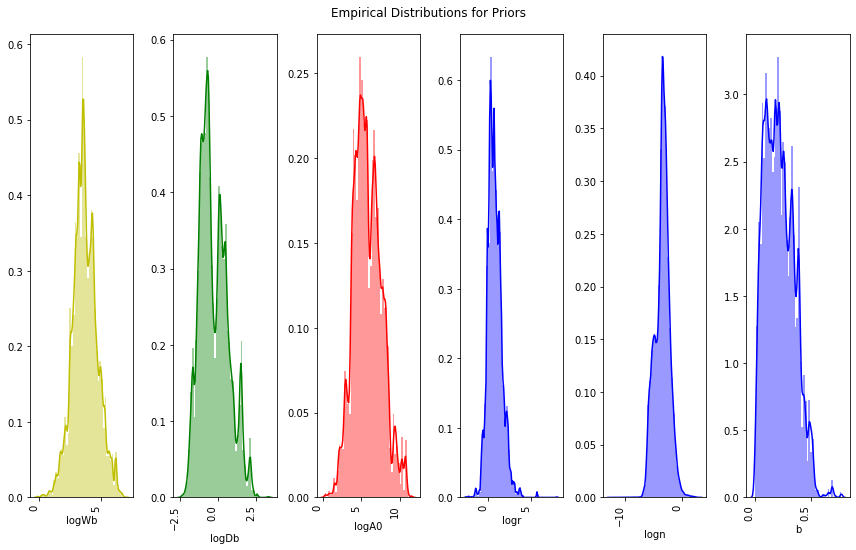

In [8]:
Hydroshortened['logA0'] = np.log(Hydroshortened['A0'])
Hydroshortened['logr'] = np.log(Hydroshortened['r'])
Hydroshortened['logn'] = np.log(Hydroshortened['n'])
Hydroshortened['logWb'] = np.log(Hydroshortened['bank_width'])
Hydroshortened['logDb'] = np.log(Hydroshortened['bank_depth'])
Hydroshortened['logQb'] = np.log(Hydroshortened['bank_Q'])
Hydroshortened['logQ'] = np.log(Hydroshortened['chan_discharge'])

Hydroshortened['log10De'] = np.log10(Hydroshortened['minEntrain'])

fig, axs = plt.subplots(ncols=6, figsize=(12, 8))
sns.distplot(Hydroshortened['logWb'], ax=axs[0], color='y')
sns.distplot(Hydroshortened['logDb'], ax=axs[1], color='g')
sns.distplot(Hydroshortened['logA0'], ax=axs[2], color='r')
sns.distplot(Hydroshortened['logr'], ax=axs[3], color='b')
sns.distplot(Hydroshortened['logn'], ax=axs[4], color='b')
sns.distplot(Hydroshortened['b'], ax=axs[5], color='b')

fig.suptitle("Empirical Distributions for Priors")
fig.autofmt_xdate(rotation=90)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])

#save prior PDFs (no river type subsetting)
priorWb = Hydroshortened['logWb'].describe()
priorDb = Hydroshortened['logDb'].describe()
prior_r = Hydroshortened['logr'].describe()
priorDe = Hydroshortened['log10De'].describe()
priorQb = Hydroshortened['logQb'].describe()
priorA0 = Hydroshortened['logA0'].describe()
priorN = Hydroshortened['logn'].describe()
priorB = Hydroshortened['b'].describe()

#if SWOTflag == 1:
   # priorWb.to_csv('priors\\final_priors\\SWOT_independent_test\\priorsWb.csv')
   # priorDb.to_csv('priors\\final_priors\\SWOT_independent_test\\priorsDb.csv')
   # prior_r.to_csv('priors\\final_priors\\SWOT_independent_test\\priorsr.csv')
   # priorDe.to_csv('priors\\final_priors\\SWOT_independent_test\\priorsDe.csv')
   # priorQb.to_csv('priors\\final_priors\\SWOT_independent_test\\priorsQb.csv')
   # priorA0.to_csv('priors\\final_priors\\SWOT_independent_test\\priorsA0.csv')
   # priorN.to_csv('priors\\final_priors\\SWOT_independent_test\\priorsN.csv')
   # priorB.to_csv('priors\\final_priors\\SWOT_independent_test\\priorsB.csv')

#else:
#    priorWb.to_csv('priors\\final_priors\\priorsWb.csv')
#    priorDb.to_csv('priors\\final_priors\\priorsDb.csv')
#    prior_r.to_csv('priors\\final_priors\\priorsr.csv')
#    priorDe.to_csv('priors\\final_priors\\priorsDe.csv')
#    priorQb.to_csv('priors\\final_priors\\priorsQb.csv')
#    priorA0.to_csv('priors\\final_priors\\priorsA0.csv')
#    priorN.to_csv('priors\\final_priors\\priorsN.csv')
#    priorB.to_csv('priors\\final_priors\\priorsB.csv')

<h4> <font color=darkolivegreen>Calculate Global Hat Functions</font> </h4>

C:\Users\craig\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


(-1, 12.5)

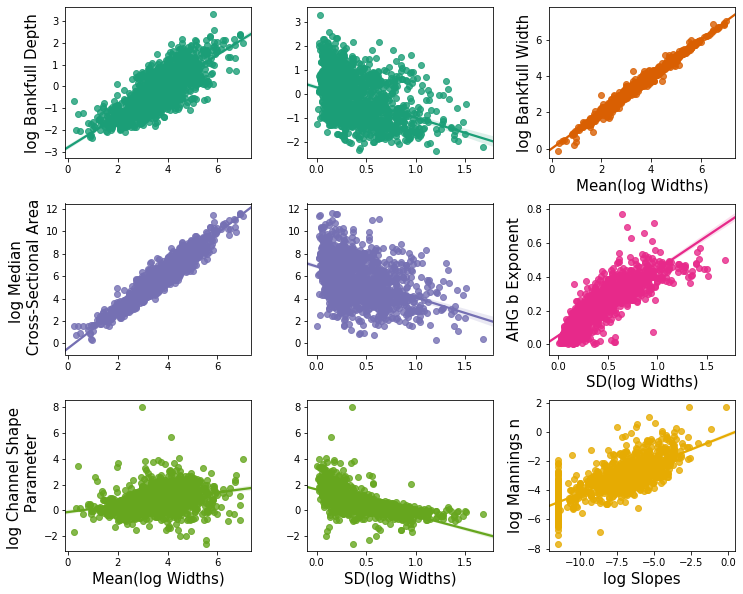

In [9]:
Hydroshortened['logchan_width'] = np.log(Hydroshortened['chan_width'])

stdWdths = Hydroshortened.groupby('site_no')['logchan_width'].std().to_frame()
stdWdths = stdWdths.rename(columns={'logchan_width':'stdWdth'})
meanWdths = Hydroshortened.groupby('site_no')['logchan_width'].mean().to_frame()
meanWdths = meanWdths.rename(columns={'logchan_width':'meanWdths'})

Hydroshortened =  pd.merge(Hydroshortened, stdWdths, on='site_no')
Hydroshortened =  pd.merge(Hydroshortened, meanWdths, on='site_no')

Hydroshortened['logSLOPE'] = np.log(Hydroshortened['SLOPE'])
Hydroshortened['log10SLOPE'] = np.log10(Hydroshortened['SLOPE'])
Hydroshortened['log10n'] = np.log10(Hydroshortened['n'])

#For non time-varying parameters, need a dataset of only one value per station
forPriors = Hydroshortened.drop_duplicates('site_no')

resultB = sm.OLS(forPriors['b'], sm.add_constant(forPriors['stdWdth'])).fit()
resultA0 = sm.OLS(forPriors['logA0'], sm.add_constant(forPriors[['meanWdths','stdWdth']])).fit()
resultWb = sm.OLS(forPriors['logWb'], sm.add_constant(forPriors[['meanWdths']])).fit()
resultDb = sm.OLS(forPriors['logDb'], sm.add_constant(forPriors[['meanWdths', 'stdWdth']])).fit()
result_r = sm.OLS(forPriors['logr'], sm.add_constant(forPriors[['meanWdths', 'stdWdth']])).fit()
resultQb = sm.OLS(forPriors['logQb'], sm.add_constant(forPriors[['meanWdths']])).fit()
resultDe = sm.OLS(forPriors['log10De'], sm.add_constant(forPriors[['log10SLOPE']])).fit()
resultN = sm.OLS(Hydroshortened['logn'], sm.add_constant(Hydroshortened[['logSLOPE']])).fit()

#get residual standard errors --> SD for hat funtions in BAM
sdWb = np.sqrt(resultWb.scale)
sdDb = np.sqrt(resultDb.scale)
sdR = np.sqrt(result_r.scale)
sdN = np.sqrt(resultN.scale)
sdB = np.sqrt(resultB.scale)
sdA0 = np.sqrt(resultA0.scale)

priorsSD = pd.DataFrame(index=['Wb','Db','r','n', 'A0', 'b'])
priorsSD['SD'] = (sdWb, sdDb, sdR, sdN, sdA0, sdB)

fig, axs = plt.subplots(ncols=3, nrows = 3, figsize=(12, 10))
sns.regplot(data = forPriors, x='meanWdths', y='logDb', ax=axs[0,0], color='#1b9e77')
sns.regplot(data = forPriors, x='stdWdth', y='logDb', ax=axs[0,1], color='#1b9e77')
sns.regplot(data = forPriors, x='meanWdths', y='logWb', ax=axs[0,2], color='#d95f02')
sns.regplot(data = forPriors, x='meanWdths', y='logA0', ax=axs[1,0], color='#7570b3')
sns.regplot(data = forPriors, x='stdWdth', y='logA0', ax=axs[1,1], color='#7570b3')
sns.regplot(data = forPriors, x='stdWdth', y='b', ax=axs[1,2], color='#e7298a')
sns.regplot(data = forPriors, x='meanWdths', y='logr', ax=axs[2,0], color='#66a61e')
sns.regplot(data = forPriors, x='stdWdth', y='logr', ax=axs[2,1], color='#66a61e')
sns.regplot(data = forPriors, x='logSLOPE', y='logn', ax=axs[2,2], color='#e6ab02')

#fig.autofmt_xdate(rotation=90)
fig.subplots_adjust(wspace = 0.3, hspace=0.3)
axs[0,0].set_ylabel('log Bankfull Depth', fontsize=15)
axs[0,1].set_ylabel('')
axs[0,2].set_ylabel('log Bankfull Width', fontsize=15)

axs[1,0].set_ylabel('log Median \n Cross-Sectional Area', fontsize=15)
axs[1,1].set_ylabel('')
axs[1,2].set_ylabel('AHG b Exponent', fontsize=15)

axs[2,0].set_ylabel('log Channel Shape \n Parameter', fontsize=15)
axs[2,1].set_ylabel('')
axs[2,2].set_ylabel('log Mannings n', fontsize=15)

axs[0,0].set_xlabel('')
axs[0,1].set_xlabel('')
axs[0,2].set_xlabel('Mean(log Widths)', fontsize=15)

axs[1,0].set_xlabel('')
axs[1,1].set_xlabel('')
axs[1,2].set_xlabel('SD(log Widths)', fontsize=15)

axs[2,0].set_xlabel('Mean(log Widths)', fontsize=15)
axs[2,1].set_xlabel('SD(log Widths)', fontsize=15)
axs[2,2].set_xlabel('log Slopes', fontsize=15)

axs[1,0].set_ylim(-1,12.5)
axs[1,1].set_ylim(-1,12.5)

#fig.savefig('prior_models.tif')

#if swotFLAG == 1:
    #priorsSD.to_csv('priors\\SWOT_independent_test\\priorSDs.csv')
#else:
    #priorsSD.to_csv('priors\\priorSDs.csv')

In [140]:
resultDe.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                log10De   R-squared:                       0.804
Model:                            OLS   Adj. R-squared:                  0.804
Method:                 Least Squares   F-statistic:                     5693.
Date:                Thu, 06 Aug 2020   Prob (F-statistic):               0.00
Time:                        14:26:41   Log-Likelihood:                -920.46
No. Observations:                1386   AIC:                             1845.
Df Residuals:                    1384   BIC:                             1855.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5103      0.042     12.221      0.000       0.428       0.592
log10SLOPE     0.8724      0.012     75.454      0.000       0.850       0.895
==============================================================================
Omnibus:                        0.891   Durbin-Watson:                   1.324
Prob(Omnibus):                  0.640   Jarque-Bera (JB):                0.965
Skew:                          -0.043   Prob(JB):                        0.617
Kurtosis:                       2.904   Cond. No.                         12.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<h2> <font color=darkolivegreen>Expert Classification </font></h2>

PCA is ran on stage-invariant features, the medians of stage-variant features, and the variances of stage-variant features at 1,409 stations
<br><br>
All told, this yields 24 predictors

In [10]:
#reduce to stations, using mean and var of observed hydraulics at-a-station
#for stage-invariant features, taking the median just selects that stage-invariant value
station_medians = Hydroshortened.groupby('site_no').median() #get average hydraulics for each station
station_medians = station_medians[['chan_width', 'n', 'SLOPE', 'StreamOrde','DistDwnstrm', 'FCODEnorm', 'chan_depth', 'chan_velocity', 'unitPower', 'r', 'DASqKm', 'Fb', 'shearStress', 'minEntrain', 'TOTMA', 'sinuosity', 'logA0', 'logn', 'b', 'logr', 'logDb', 'logWb']]#, 'CAT_SILTAVE', 'CAT_SANDAVE', 'CAT_CLAYAVE']]
station_var = Hydroshortened.groupby('site_no').var() #get average hydraulics for each station
station_var = station_var[['chan_velocity', 'chan_depth', 'chan_width', 'n', 'unitPower', 'Fb', 'shearStress', 'minEntrain']]

station_var.columns = ['velocity_var','depth_var','width_var',
                     'n_var','unitPower_var','Fb_var',
                      'shearStress_var', 'minEntrain_var']

pca_df = station_medians.merge(station_var, on='site_no')
pca_df

#for DBSCAN later
dbscan_df = pca_df

In [11]:
#run PCA on these features
features = ['chan_width', 'n', 'SLOPE', 'StreamOrde','DistDwnstrm', 'FCODEnorm', 'chan_depth', 'chan_velocity', 
            'unitPower', 'r', 'DASqKm', 'Fb', 'shearStress', 'minEntrain', 'TOTMA', 'sinuosity', 'velocity_var',
            'depth_var','width_var', 'n_var','unitPower_var','Fb_var','shearStress_var', 'minEntrain_var']#, 
            #'CAT_SILTAVE', 'CAT_SANDAVE', 'CAT_CLAYAVE']
x = pca_df.loc[:, features].values # Separating out the features
#y = temp.loc[:,['site_no']].values # Separating out the target
x = StandardScaler().fit_transform(x) # normalizing the features

pca = PCA(n_components=3) #ran using 3 PCs
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = pca.components_
             , columns = ['chan_width', 'n', 'SLOPE', 'StreamOrde','DistDwnstrm', 'FCODEnorm', 'chan_depth', 'chan_velocity', 
            'unitPower', 'r', 'DASqKm', 'Fb', 'shearStress', 'minEntrain', 'TOTMA', 'sinuosity', 'velocity_var',
            'depth_var','width_var', 'n_var','unitPower_var','Fb_var','shearStress_var', 'minEntrain_var'])#,
            #'CAT_SILTAVE', 'CAT_SANDAVE', 'CAT_CLAYAVE'])

array([0.33394675, 0.12816737, 0.07962474, 0.06946866, 0.04658335,
       0.04223498, 0.04172036, 0.04144051])

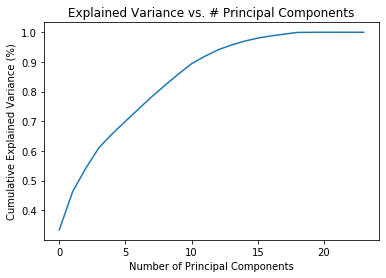

In [12]:
#Plot PCA results
pca = PCA().fit(x)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance (%)')
plt.title('Explained Variance vs. # Principal Components')

principalDf.transpose()
pca.explained_variance_ratio_[0:8]

<h4> <font color=darkolivegreen>PCA Results </font> </h4>
PC1: 'Sediment Transport' explains 33% of variance <br>
PC2: 'River Size' explains 12% of variance <br>
PC3: 'Velocity/Fb Variance' explains 8% of variance <br>
All other PCs explain < 7% of dataset variability

<h4> <font color=darkolivegreen>Clustering PCA Results </font> </h4>
Ultimately, I settled on 15 river types, plus 'big' rivers and 'highly width-variable' rivers (17 total).  This was the largest # of classes I could bin before class median width began overlapping with other classes (i.e. here, the classification was forced to incremently increase observed widths with river type).  If I used less classes, the largest river type was still 'too small' as well.  Also, less classes yielded larger SD of priors which I believe contributes to significant run time issues with geoBAM.

In [16]:
#15 classes is the largest number before class median widths overlap
quantiles = [0.067, 0.134, 0.201, 0.268, 0.335, 0.402, 0.469, 0.536, 0.603, 0.670, 0.737, 0.804, 0.871, 0.938]

#add PC values to hydroshortened
pca_df['PC1'] = principalComponents[:,0]
pca_df['PC2'] = principalComponents[:,1]
pca_df['PC3'] = principalComponents[:,2]
#pca_df['PC4'] = principalComponents[:,3]

pca_df['geomorphIndex'] = (pca_df['PC1'])+(pca_df['PC2'])+(pca_df['PC3'])#+(pca_df['PC4'])
geomorphIndex = np.quantile(pca_df['geomorphIndex'], quantiles)

pca_df['clusterGeomorphIndex'] = np.where(pca_df['logr']<0, '16',
                                          np.where(pca_df['geomorphIndex']<geomorphIndex[0], '1', 
                                               np.where(pca_df['geomorphIndex']<geomorphIndex[1], '2', 
                                                       np.where(pca_df['geomorphIndex']<geomorphIndex[2], '3', 
                                                               np.where(pca_df['geomorphIndex']<geomorphIndex[3], '4',
                                                                        np.where(pca_df['geomorphIndex']<geomorphIndex[4], '5',
                                                                                 np.where(pca_df['geomorphIndex']<geomorphIndex[5], '6',
                                                                                          np.where(pca_df['geomorphIndex']<geomorphIndex[6], '7', 
                                                                                                   np.where(pca_df['geomorphIndex']<geomorphIndex[7], '8',
                                                                                                            np.where(pca_df['geomorphIndex']<geomorphIndex[8], '9',
                                                                                                                    np.where(pca_df['geomorphIndex']<geomorphIndex[9], '10',
                                                                                                                             np.where(pca_df['geomorphIndex']<geomorphIndex[10], '11',
                                                                                                                                      np.where(pca_df['geomorphIndex']<geomorphIndex[11], '12',
                                                                                                                                               np.where(pca_df['geomorphIndex']<geomorphIndex[12], '13',
                                                                                                                                                   np.where(pca_df['geomorphIndex']<geomorphIndex[13], '14','15')))))))))))))))


temp = pca_df[['logchan_width', 'clusterGeomorphIndex']]
temp.to_csv('priors\\final_priors\\expert_river_widths.csv')

<h4> <font color=darkolivegreen>Prior Distributions by River Type</font> </h4>
Note the final panel, where river type width systematically increases with river type.  This was forced through the classification, hence the 'expert' name.
<br><br>
The 'magnitude priors' (Wb, Db, A0) all increase with river type just like width does (as makes sense).  Channel shape r mostly increases with river type (bigger rivers are generally more rectangular, so this makes sense) and b decreases (again, given larger rivers are more rectangular).  Interesitngly, Manning's n does not meaningfully change with river type.  Only river type 1 (the smallest of rivers) has notably higher Manning's n values (which corroborates basic geomorphic theory).
<br><br>
It is unclear whether the design of this classification cannot account for n variability, or if Manning's n does not readily change with river size in these 1,409 cross-sections.

Text(0.5, 77.05000000000004, '')

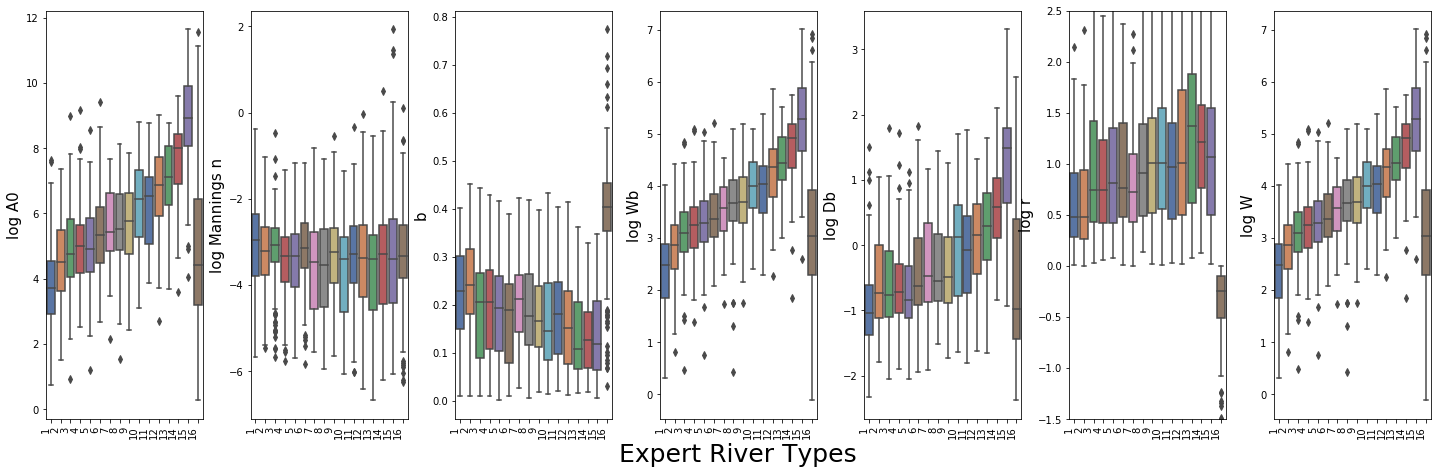

In [14]:
pca_df['logchan_width'] = np.log(pca_df['chan_width']) #mean at-a-station width

fig, axs = plt.subplots(ncols=7, figsize=(20, 7))
sns.boxplot(x="clusterGeomorphIndex", y='logA0', data=pca_df, palette='deep', ax=axs[0], order=['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16'])
sns.boxplot(x="clusterGeomorphIndex", y='logn', data=pca_df, palette='deep', ax=axs[1], order=['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16'])
sns.boxplot(x="clusterGeomorphIndex", y='b', data=pca_df, palette='deep', ax=axs[2], order=['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16'])
sns.boxplot(x="clusterGeomorphIndex", y='logWb', data=pca_df, palette='deep', ax=axs[3], order=['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16'])
sns.boxplot(x="clusterGeomorphIndex", y='logDb', data=pca_df, palette='deep', ax=axs[4], order=['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16'])
sns.boxplot(x="clusterGeomorphIndex", y='logr', data=pca_df, palette='deep', ax=axs[5], order=['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16'])
sns.boxplot(x="clusterGeomorphIndex", y='logchan_width', data=pca_df, palette='deep', ax=axs[6], order=['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16'])

fig.autofmt_xdate(rotation=90)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])

axs[0].set_ylabel('log A0', fontsize=15)
axs[1].set_ylabel('log Mannings n', fontsize=15)
axs[2].set_ylabel('b', fontsize=15)
axs[3].set_ylabel('log Wb', fontsize=15)
axs[4].set_ylabel('log Db', fontsize=15)
axs[5].set_ylabel('log r', fontsize=15)
axs[6].set_ylabel('log W', fontsize=15)

axs[5].set_ylim(-1.5,2.5)

axs[0].set_xlabel('')
axs[1].set_xlabel('')
axs[2].set_xlabel('')
axs[3].set_xlabel('Expert River Types', fontsize=25)
axs[4].set_xlabel('')
axs[5].set_xlabel('')
axs[6].set_xlabel('')

#fig.savefig('expert_priors.tif')

In [45]:
#maps class to river based on 'closest' median cross-sectional average width of each class
binnedMeanWdths = pca_df.groupby('clusterGeomorphIndex')['logchan_width'].describe()
binnedMeanWdths.to_csv('priors\\final_priors\\SWOT_independent_test\\WidthsClass_geoBAMexpert.csv')

#save prior distribution parameters
priorWbClass = pca_df.groupby('clusterGeomorphIndex')['logWb'].describe()
priorDbClass = pca_df.groupby('clusterGeomorphIndex')['logDb'].describe()
prior_rClass = pca_df.groupby('clusterGeomorphIndex')['logr'].describe()
priorA0Class = pca_df.groupby('clusterGeomorphIndex')['logA0'].describe()
priorNClass = pca_df.groupby('clusterGeomorphIndex')['logn'].describe()
priorBClass = pca_df.groupby('clusterGeomorphIndex')['b'].describe()

priorWbClass.to_csv('priors\\final_priors\\SWOT_independent_test\\priorsWb_geoBAMexpert.csv')
priorDbClass.to_csv('priors\\final_priors\\SWOT_independent_test\\priorsDb_geoBAMexpert.csv')
prior_rClass.to_csv('priors\\final_priors\\SWOT_independent_test\\priorsR_geoBAMexpert.csv')
priorA0Class.to_csv('priors\\final_priors\\SWOT_independent_test\\priorsA0_geoBAMexpert.csv')
priorNClass.to_csv('priors\\final_priors\\SWOT_independent_test\\priorsN_geoBAMexpert.csv')
priorBClass.to_csv('priors\\final_priors\\SWOT_independent_test\\priorsB_geoBAMexpert.csv')

<h2> <font color=darkolivegreen>Unsupervised Classification </font></h2>

<h4> <font color=darkolivegreen> DBSCAN </font></h4>

Text(0, 0.5, 'Euclidean Distance')

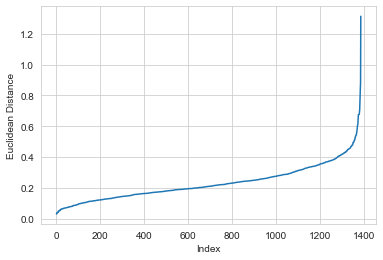

In [120]:
from sklearn.cluster import DBSCAN 
from sklearn.preprocessing import StandardScaler 
from sklearn.preprocessing import normalize 
from sklearn.neighbors import NearestNeighbors
sns.set_style("whitegrid")

features = dbscan_df[['chan_width', 'n', 'SLOPE', 'StreamOrde','DistDwnstrm', 'FCODEnorm', 'chan_depth', 'chan_velocity', 
            'unitPower', 'r', 'DASqKm', 'Fb', 'shearStress', 'minEntrain', 'TOTMA', 'sinuosity', 'velocity_var',
            'depth_var','width_var', 'n_var','unitPower_var','Fb_var','shearStress_var', 'minEntrain_var']]

# Scaling the data to bring all the attributes to a comparable level 
scaler = StandardScaler() 
X_scaled = scaler.fit_transform(features) 
  
# Normalizing the data so that the data 
# approximately follows a Gaussian distribution 
X_normalized = normalize(X_scaled) 
  
# Converting the numpy array into a pandas DataFrame 
X_normalized = pd.DataFrame(X_normalized) 
  
# Renaming the columns 
X_normalized.columns = features.columns 

neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(X_normalized)
distances, indices = nbrs.kneighbors(X_normalized)

distances = np.sort(distances, axis=0)
distances = distances[:,1]

fig = plt.figure()
plt.plot(distances)
plt.xlabel('Index')
plt.ylabel('Euclidean Distance')

#fig.savefig('optimal_eps.tif')

This is a plot of distance to n-nearest neighbors for the 1,409 points in the feature space.  Optimal epsilon occurs at the point of steepest curve.  This is approximately 0.5

In [152]:
#run DBSCAN
# Numpy array of all the cluster labels assigned to each data point 
db_default = DBSCAN(eps = 0.55, min_samples = 5).fit(X_normalized)
labels = db_default.labels_ 

In [153]:
from sklearn import metrics

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)

dbscan_df['cluster'] = labels
dbscan_df['logchan_width'] = np.log(dbscan_df['chan_width'])
dbscan_df.groupby('cluster')['logr'].describe()

Estimated number of clusters: 7
Estimated number of noise points: 33


,count,mean,std,min,25%,50%,75%,max
cluster,,,,,,,,
-1,33.0,1.291614,1.836579,-1.487340,0.077579,0.883077,1.883899,8.037716
0,1243.0,0.823532,0.812986,-1.694463,0.268002,0.727928,1.291568,4.058324
1,21.0,0.777324,1.227456,-2.580471,0.101587,0.880433,1.716987,2.701881
2,25.0,0.073789,1.205119,-2.297051,-0.684620,0.303822,0.717793,2.311889
3,6.0,0.770965,0.744723,-0.374243,0.398933,0.917785,1.100232,1.777431
4,33.0,-0.171855,0.425117,-0.827781,-0.404198,-0.288883,0.064091,0.991361
5,20.0,0.570701,0.983103,-0.636078,-0.104936,0.212007,1.033947,2.674956
6,5.0,0.993440,1.012247,-0.102398,0.497026,0.765349,1.217159,2.590066


Text(0.5, 80.80000000000004, '')

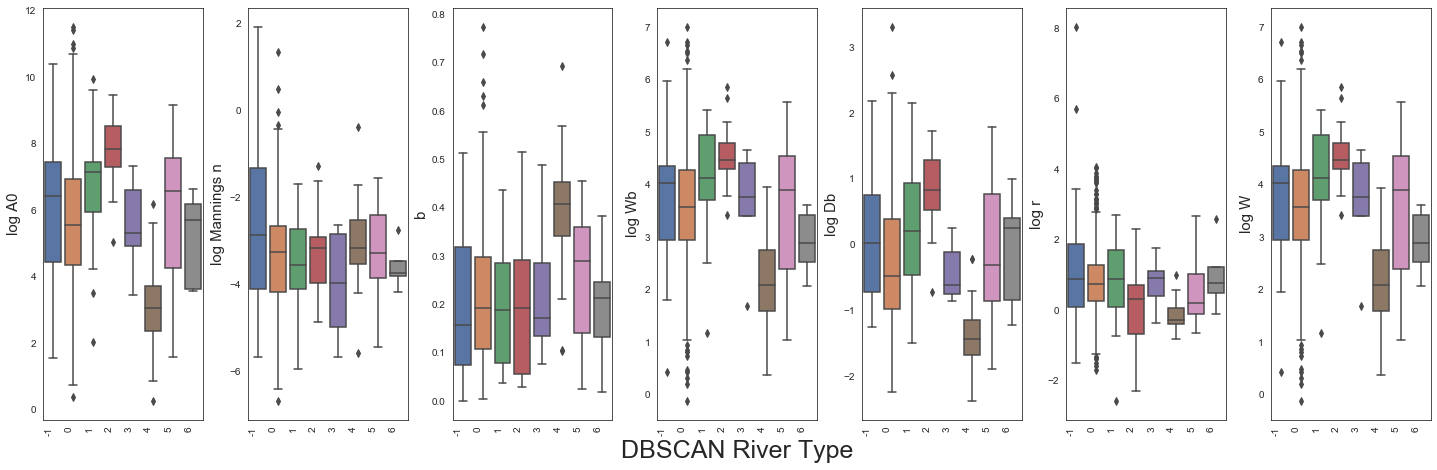

In [154]:
sns.set_style("white")

fig, axs = plt.subplots(ncols=7, figsize=(20, 7))
sns.boxplot(x="cluster", y='logA0', data=dbscan_df, palette='deep', ax=axs[0])
sns.boxplot(x="cluster", y='logn', data=dbscan_df, palette='deep', ax=axs[1])
sns.boxplot(x="cluster", y='b', data=dbscan_df, palette='deep', ax=axs[2])
sns.boxplot(x="cluster", y='logWb', data=dbscan_df, palette='deep', ax=axs[3])
sns.boxplot(x="cluster", y='logDb', data=dbscan_df, palette='deep', ax=axs[4])
sns.boxplot(x="cluster", y='logr', data=dbscan_df, palette='deep', ax=axs[5])
sns.boxplot(x="cluster", y='logchan_width', data=dbscan_df, palette='deep', ax=axs[6])

fig.autofmt_xdate(rotation=90)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])

axs[0].set_ylabel('log A0', fontsize=15)
axs[1].set_ylabel('log Mannings n', fontsize=15)
axs[2].set_ylabel('b', fontsize=15)
axs[3].set_ylabel('log Wb', fontsize=15)
axs[4].set_ylabel('log Db', fontsize=15)
axs[5].set_ylabel('log r', fontsize=15)
axs[6].set_ylabel('log W', fontsize=15)

axs[0].set_xlabel('')
axs[1].set_xlabel('')
axs[2].set_xlabel('')
axs[3].set_xlabel('DBSCAN River Type', fontsize=25)
axs[4].set_xlabel('')
axs[5].set_xlabel('')
axs[6].set_xlabel('')

#fig.savefig('dbscan_priors.tif')

In [156]:
#save prior distribution parameters
priorWbClass = dbscan_df.groupby('cluster')['logWb'].describe()
priorDbClass = dbscan_df.groupby('cluster')['logDb'].describe()
prior_rClass = dbscan_df.groupby('cluster')['logr'].describe()
priorA0Class = dbscan_df.groupby('cluster')['logA0'].describe()
priorNClass = dbscan_df.groupby('cluster')['logn'].describe()
priorBClass = dbscan_df.groupby('cluster')['b'].describe()

priorWbClass.to_csv('priors\\final_priors\\SWOT_independent_test\\priorsWb_geoBAMunsupervised.csv')
priorDbClass.to_csv('priors\\final_priors\\SWOT_independent_test\\priorsDb_geoBAMunsupervised.csv')
prior_rClass.to_csv('priors\\final_priors\\SWOT_independent_test\\priorsR_geoBAMunsupervised.csv')
priorA0Class.to_csv('priors\\final_priors\\SWOT_independent_test\\priorsA0_geoBAMunsupervised.csv')
priorNClass.to_csv('priors\\final_priors\\SWOT_independent_test\\priorsN_geoBAMunsupervised.csv')
priorBClass.to_csv('priors\\final_priors\\SWOT_independent_test\\priorsB_geoBAMunsupervised.csv')

<h4> <font color=darkolivegreen> Predictive model for unsupervised classes </font></h4>

In [161]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

#dbscan_df['width_sd'] = np.sqrt(dbscan_df['width_var'])

#temp = data.drop_duplicates('site_no')
X = dbscan_df[['chan_width']]
y = dbscan_df['cluster']

#Train/Test split
X_train, X_test, y_train, y_test = train_test_split(
     X, y, test_size=0.20, random_state=70)

#'One-vs-rest logistic' regression used so I can manually implement the model in geoBAM
clf = LogisticRegression(random_state=0, multi_class='ovr').fit(X_train, y_train)
# Train model
model = clf.fit(X, y)

model.predict(X_test)
model.score(X_test, y_test) #87% accuracy
model.coef_
model.intercept_

C:\Users\craig\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\craig\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


array([-3.73424617,  2.19725752, -4.11589748, -4.0251444 , -4.28494712,
       -1.1627484 , -3.96934945, -3.08417603])

In [158]:
predict = model.predict_proba(X_test)


predict = np.argmax(predict, axis=1)
predict = predict - 1

from sklearn.metrics import accuracy_score
accuracy_score(y_test, predict)

0.920863309352518